In [6]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import get_scheduler
import pandas as pd
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [7]:
from nltk.corpus import stopwords
import nltk
import gensim
import re

nltk.download('stopwords')
stop_words = stopwords.words('russian')

def preprocess(text, join_back=True):
    text =  re.sub(r'\n', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = text.lower()

    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words:
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df_train = pd.read_csv("/kaggle/input/propaganda-detection-our-data/fake_detection_df_train.csv")
df_train["text_clean"] = df_train["text"].apply(preprocess)

df_val = pd.read_csv("/kaggle/input/propaganda-detection-our-data/fake_detection_df_val.csv")
df_val["text_clean"] = df_val["text"].apply(preprocess)

df_train = pd.concat([df_train, df_val]).reset_index(drop=True)

df_test = pd.read_csv('/kaggle/input/propaganda-detection-our-data/fake_detection_df_test.csv')
df_test["text_clean"] = df_test["text"].apply(preprocess)

In [9]:
model_id = "DeepPavlov/rubert-base-cased"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def initialize_model(model_id):
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=1)
    model.to(device)
    return model

tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(inp):
    return tokenizer(inp, padding=True, truncation=True, max_length=512, return_tensors='pt')


In [10]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, data, targets):
        super().__init__()
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [11]:
def get_roc_auc(model, X, Y):
    model.eval()
    all_preds = np.array([])
    all_targets = np.array([])
    
    ds = CustomDataset(X, Y)
    loader = DataLoader(ds, batch_size=batch_size)
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            targets = batch[1].float().to(device)
            outputs = model(**tokenize(inputs).to(device))
            preds = torch.sigmoid(outputs.logits)
            all_preds = np.append(all_preds, preds.squeeze().cpu().float().numpy())
            all_targets = np.append(all_targets, targets.cpu().numpy())
    
    model.train()
    return roc_auc_score(all_targets, all_preds)

In [12]:
from torch.utils.data import DataLoader


batch_size=16
criterion = torch.nn.BCEWithLogitsLoss()


test_dataset = CustomDataset(df_test['text_clean'], df_test['label'])
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [39]:
from tqdm.auto import tqdm


def train_loop(model, X_train, Y_train, X_test, Y_test, lr, num_epochs):
    train_dataset = CustomDataset(X_train, Y_train)
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    
    log_dict = {
        'train_step_loss': [],
        'train_epoch_loss': [],
        'test_epoch_loss': []
    }
    optimizer = AdamW(model.parameters(), lr=lr)
    
    num_training_steps = num_epochs * len(train_dataloader)
    progress_bar = tqdm(range(num_training_steps))
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=10, num_training_steps=num_training_steps
    )
#     lr_scheduler = get_scheduler(
#         name="constant", optimizer=optimizer
#     )
    
    model.train()
    for epoch in range(num_epochs):
        
        
        for batch in train_dataloader:
            inputs = batch[0]
            targets = batch[1].float().unsqueeze(1).to(device)
            outputs = model(**tokenize(inputs).to(device))
            loss = criterion(outputs.logits, targets)
            
            log_dict['train_step_loss'].append(loss.item())
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        log_dict['train_epoch_loss'].append(get_roc_auc(model, X_train, Y_train))
        log_dict['test_epoch_loss'].append(get_roc_auc(model, X_test, Y_test))
    return log_dict

In [72]:
model = initialize_model(model_id)
history = train_loop(model, df_train['text_clean'], df_train['label'], df_test['text_clean'], df_test['label'], 2e-6, 15)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

  0%|          | 0/945 [00:00<?, ?it/s]

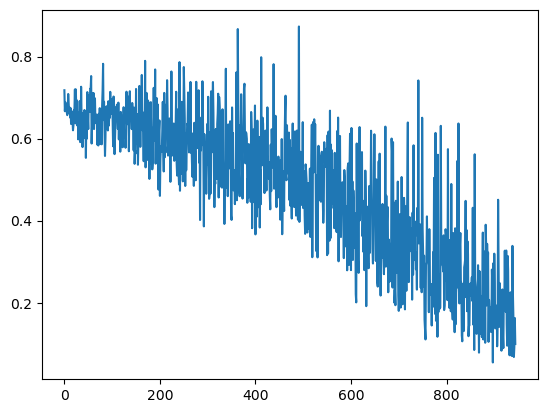

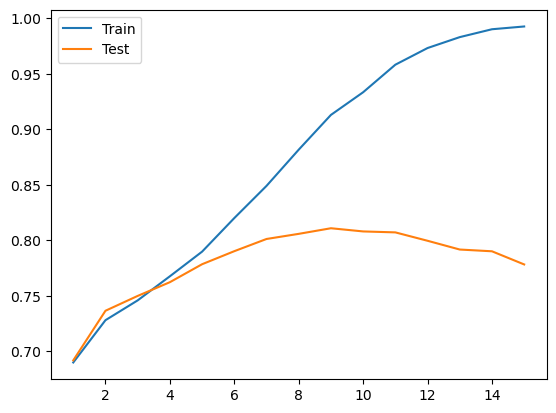

In [73]:
plt.plot(history['train_step_loss'])
plt.show()

plt.plot(range(1, 1 + len(history['train_epoch_loss'])), history['train_epoch_loss'], label='Train')
plt.plot(range(1, 1 + len(history['test_epoch_loss'])), history['test_epoch_loss'], label='Test')
plt.legend()

plt.show()

In [74]:
history['test_epoch_loss']

[0.6918685235298001,
 0.7365520427694542,
 0.7499174971949044,
 0.7622929179592106,
 0.7784634677579038,
 0.7902118672034849,
 0.8012012408421886,
 0.8058213979275296,
 0.8108705695993663,
 0.8079994719820475,
 0.8071414428090555,
 0.7995841858623193,
 0.7916969176952017,
 0.7901128638373704,
 0.778265461025675]

### What happens with usual learning rate

In [77]:
model = initialize_model(model_id)
history = train_loop(model, df_train['text_clean'], df_train['label'], df_test['text_clean'], df_test['label'], 3e-4, 10)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

  0%|          | 0/630 [00:00<?, ?it/s]

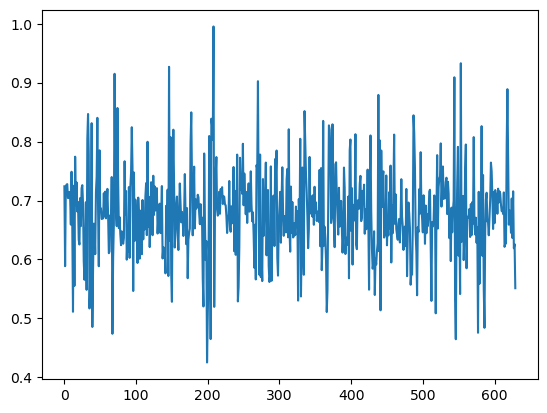

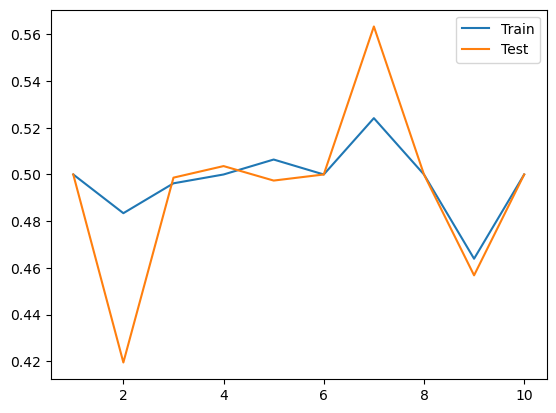

In [78]:
plt.plot(history['train_step_loss'])
plt.show()

plt.plot(range(1, 1 + len(history['train_epoch_loss'])), history['train_epoch_loss'], label='Train')
plt.plot(range(1, 1 + len(history['test_epoch_loss'])), history['test_epoch_loss'], label='Test')
plt.legend()

plt.show()

In [11]:
def get_preds(model, tokenizer, data):
    model.eval()
    with torch.no_grad():
        res = data.apply(lambda x: torch.sigmoid(model(**tokenize(x).to(device)).logits).item())
    model.train()
    return res

In [12]:
def self_training(
    model_id, X_train, Y_train, X_test, Y_test, 
    num_epochs, lr, rounds, 
    unlabeled_data, confidence_threshold
    ):
    
    rounds_history = {}
    
    full_X = X_train
    full_Y = Y_train
    for round_ in range(rounds):
        print("Round", round_)
        
        model = initialize_model(model_id)
        epoch_history = train_loop(model, full_X, full_Y, X_test, Y_test, lr, num_epochs)
        
        
        
        rounds_history[f"Round_{round_ + 1}"] = epoch_history
        rounds_history[f"Round_{round_ + 1}"]['proba'] = get_preds(model, tokenizer, X_test)
        
        if round_ != rounds - 1:
            preds_unlabeled = get_preds(model, tokenizer, unlabeled_data)
        
            confident_pseudo_examples = unlabeled_data[
                (preds_unlabeled > confidence_threshold) | (preds_unlabeled < (1 - confidence_threshold))
            ]

            confident_pseudo_labels = preds_unlabeled[
                (preds_unlabeled > confidence_threshold) | (preds_unlabeled < (1 - confidence_threshold))
            ]

            confident_pseudo_labels = confident_pseudo_labels.apply(lambda x: 1 if x > confidence_threshold else 0)
            
            print(f"Added {len(confident_pseudo_labels)} rows")


            full_X = pd.concat([X_train, confident_pseudo_examples]).reset_index(drop=True)
            full_Y = pd.concat([Y_train, confident_pseudo_labels]).reset_index(drop=True)
            
            del model 
            torch.cuda.empty_cache()
    
    return model, rounds_history

In [13]:
unlabeled_data = pd.read_csv('/kaggle/input/ru-propaganda-2022-year/text_table_processed.csv', nrows=50000)

In [14]:
clean_unlabeled_data = unlabeled_data[unlabeled_data['lang'] == 'ru']['Text_processed'].dropna().apply(preprocess)

In [15]:
model, history = self_training(
    model_id, df_train['text_clean'], df_train['label'], df_test['text_clean'], df_test['label'],
    num_epochs=5, lr=5e-6, rounds=3,
    unlabeled_data=clean_unlabeled_data, confidence_threshold=0.96
)

Round 0


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

  0%|          | 0/315 [00:00<?, ?it/s]

Added 1522 rows
Round 1


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

  0%|          | 0/795 [00:00<?, ?it/s]

Added 24881 rows
Round 2


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

  0%|          | 0/8090 [00:00<?, ?it/s]

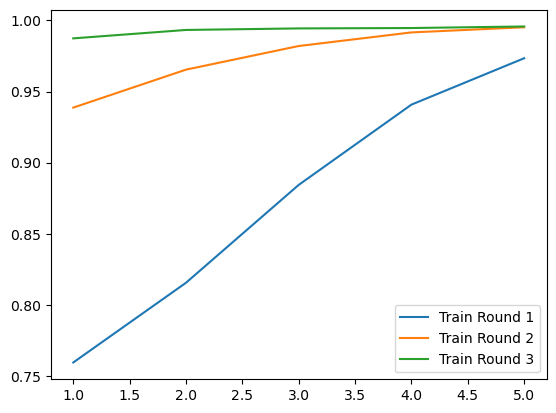

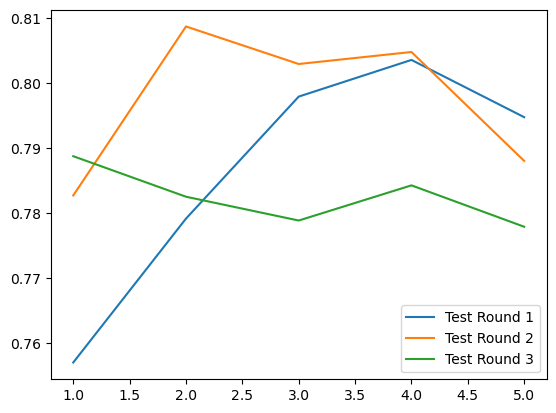

In [16]:
import matplotlib.pyplot as plt

for i in range(1, 4):
    plt.plot(range(1, 1 + len(history[f"Round_{i}"]['train_epoch_loss'])), history[f"Round_{i}"]['train_epoch_loss'], label=f'Train Round {i}')
    plt.legend()

plt.show()

for i in range(1, 4):
    plt.plot(range(1, 1 + len(history[f"Round_{i}"]['test_epoch_loss'])), history[f"Round_{i}"]['test_epoch_loss'], label=f'Test Round {i}')
    plt.legend()

plt.show()

In [14]:
model_id = "xlm-roberta-base"


def initialize_model(model_id):
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=1)
    model.to(device)
    return model

tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(inp):
    return tokenizer(inp, padding=True, truncation=True, max_length=512, return_tensors='pt')



model = initialize_model(model_id)
history = train_loop(model, df_train['text_clean'], df_train['label'], df_test['text_clean'], df_test['label'], 5e-6, 10)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

  0%|          | 0/630 [00:00<?, ?it/s]

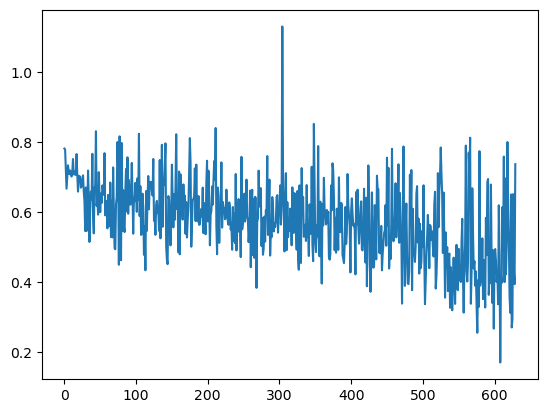

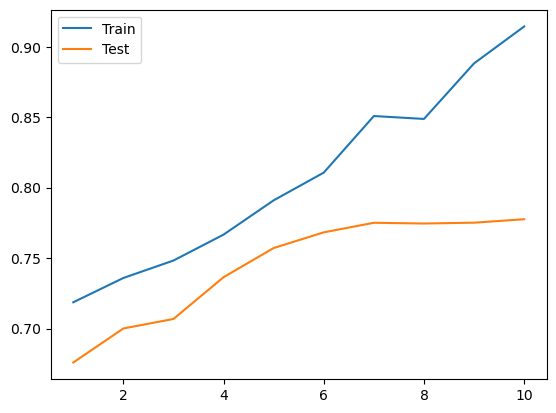

In [15]:
plt.plot(history['train_step_loss'])
plt.show()

plt.plot(range(1, 1 + len(history['train_epoch_loss'])), history['train_epoch_loss'], label='Train')
plt.plot(range(1, 1 + len(history['test_epoch_loss'])), history['test_epoch_loss'], label='Test')
plt.legend()

plt.show()

In [51]:
model_id = "DeepPavlov/rubert-base-cased"
model = initialize_model(model_id)

tokenizer = AutoTokenizer.from_pretrained(model_id)
history = train_loop(model, df_train['text_clean'], df_train['label'], df_test['text_clean'], df_test['label'], 2e-5, 3)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

  0%|          | 0/189 [00:00<?, ?it/s]

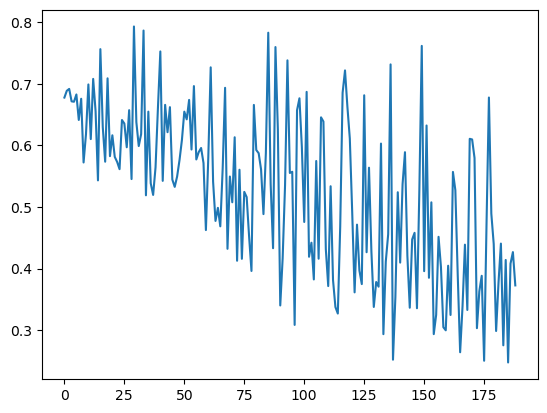

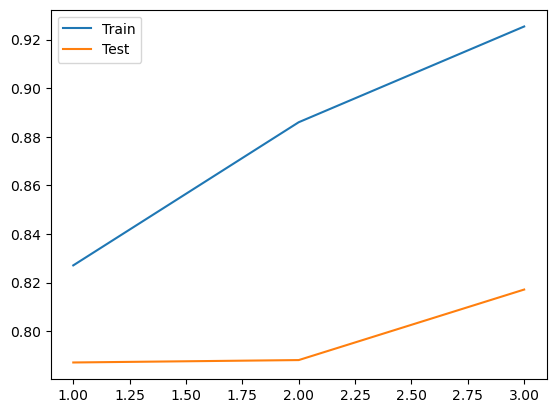

In [52]:
plt.plot(history['train_step_loss'])
plt.show()

plt.plot(range(1, 1 + len(history['train_epoch_loss'])), history['train_epoch_loss'], label='Train')
plt.plot(range(1, 1 + len(history['test_epoch_loss'])), history['test_epoch_loss'], label='Test')
plt.legend()

plt.show()

In [59]:
history['test_epoch_loss']

[0.7870767606098606, 0.7880667942710052, 0.8171077816645765]

In [ ]:
model.save_pretrained('bert_final_model')